# Generative Adversarial Network for ECG synthesis


![](https://64.media.tumblr.com/66dc00e688f72af4d7b5d768005359c4/094fefb7e60b17ee-9c/s500x750/3060385c5fdcb38f3a716d8a309a40e69e598a5f.png)

## Introducción

Este notebook implementa una Red Generativa Adversaria (GAN) unidimensional para la síntesis de señales de electrocardiograma (ECG). El objetivo es generar señales ECG sintéticas que mantengan las características principales de las señales reales correspondientes a diferentes patologías cardíacas.

### Objetivos
- Entrenar un modelo GAN para generar señales ECG sintéticas
- Evaluar la calidad de las señales generadas comparándolas con señales reales
- Contribuir al aumento de datos para mejorar el diagnóstico automático de patologías cardíacas

## Instalación de dependencias

Instalamos PyTorch, la librería principal para el desarrollo de modelos de deep learning que utilizaremos para implementar nuestra GAN.

In [2]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 8.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 MB 38.7 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 36.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [torchvision] [torchvision]


## Importación de librerías

Importamos todas las librerías necesarias para el procesamiento de datos, visualización y desarrollo del modelo GAN.

In [11]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


## Configuración del entorno

Definimos la configuración global del proyecto y establecemos la semilla para asegurar la reproducibilidad de los resultados.

In [12]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

## Carga y preparación de datos

### Dataset MIT-BIH y PTB-DB
Cargamos los datasets de ECG que contienen diferentes tipos de arritmias y patologías cardíacas:
- **MIT-BIH Arrhythmia Database**: Contiene registros de ECG con diferentes tipos de arritmias
- **PTB Diagnostic ECG Database**: Contiene registros de ECG de pacientes con patologías cardíacas

In [13]:
df_ptbdb = pd.read_csv('./ECG_DATASET_V2/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('./ECG_DATASET_V2/mitbih_train.csv')
df_ptbdb.head()

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
df_mitbih_train = pd.read_csv('./ECG_DATASET_V2/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('./ECG_DATASET_V2/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


### Procesamiento del dataset MIT-BIH
Combinamos los datos de entrenamiento y prueba del dataset MIT-BIH, y creamos etiquetas descriptivas para cada clase de arritmia.

In [15]:
#df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

# Análisis Exploratorio de Datos (EDA)

En esta sección realizamos un análisis exploratorio para comprender la distribución de las clases en nuestro dataset y visualizar las características de las señales ECG.

In [16]:
!pwd

/home/hinton2/Documents/proyecto_moises/Tesis-MIA-UNI/notebooks


In [17]:
df = pd.read_csv("./data.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,class,label
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


### Visualización de los datos
Cargamos el dataset procesado y examinamos su estructura y contenido.

In [18]:
df['label'].value_counts()

label
Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: count, dtype: int64

### Distribución de clases
Analizamos la distribución de las diferentes clases de arritmias en nuestro dataset para identificar posibles desbalances.

/tmp/ipykernel_333518/3480477453.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
/tmp/ipykernel_333518/3480477453.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15);


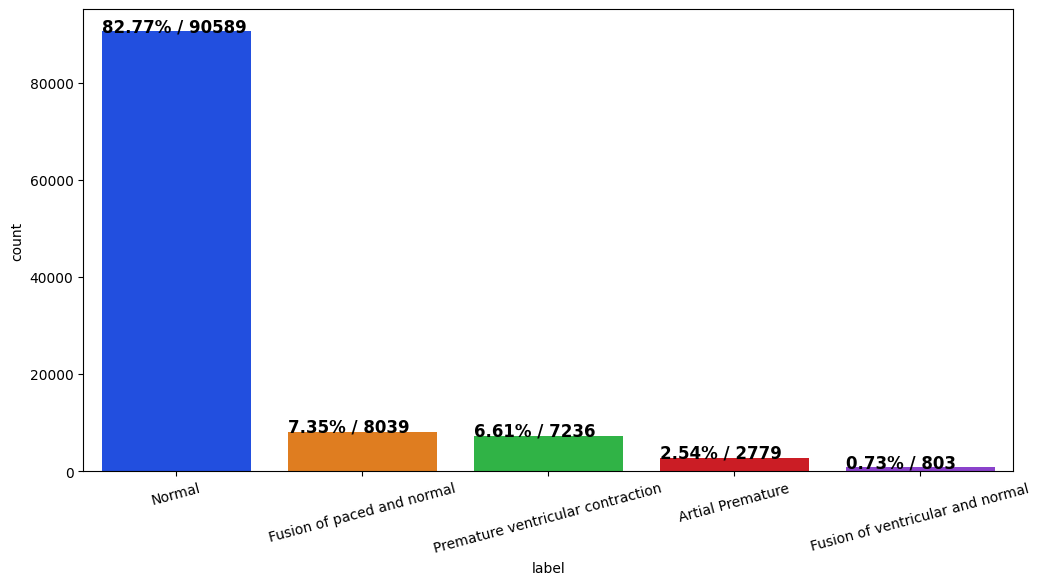

In [19]:
percentages = [count / df.shape[0] * 100 for count in df['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df['label'],
    ax=ax,
    palette="bright",
    order=df['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

### Gráfico de distribución de clases
Creamos una visualización detallada que muestra tanto el conteo como el porcentaje de cada clase en el dataset.

# Preparación del Dataset para PyTorch

En esta sección implementamos las clases necesarias para manejar los datos de ECG con PyTorch, incluyendo un Dataset personalizado y DataLoader para el entrenamiento del modelo.

In [20]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

29


/tmp/ipykernel_333518/3944258185.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  signal = torch.FloatTensor([signal.values])


(torch.Size([96, 1, 187]), torch.Size([96]))

### Clase ECGDataset
Implementamos una clase personalizada de Dataset que hereda de `torch.utils.data.Dataset` para manejar específicamente datos de ECG.

### Función get_dataloader
Función auxiliar que crea un DataLoader filtrado por tipo de arritmia, permitiendo entrenar el modelo con una clase específica.

# Arquitectura de la GAN

En esta sección definimos las arquitecturas del Generador y Discriminador que componen nuestra Red Generativa Adversaria (GAN) para síntesis de señales ECG unidimensionales.

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

## Generador
El **Generador** es responsable de crear señales ECG sintéticas a partir de ruido aleatorio. Su arquitectura incluye:
- Una capa LSTM bidireccional para capturar dependencias temporales
- Capas completamente conectadas con activación LeakyReLU
- Dropout para regularización

## Discriminador  
El **Discriminador** actúa como un clasificador binario que distingue entre señales reales y sintéticas. Su arquitectura incluye:
- Una capa LSTM bidireccional para análisis de secuencias temporales
- Capas completamente conectadas con activación LeakyReLU
- Función sigmoide en la salida para probabilidad binaria

# Entrenamiento de la GAN

Esta sección implementa el proceso de entrenamiento de la GAN utilizando el algoritmo estándar donde el Generador y Discriminador compiten en un juego de suma cero.

In [22]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

## Clase Trainer
La clase `Trainer` encapsula todo el proceso de entrenamiento de la GAN:

### Componentes principales:
- **Optimizadores**: Adam para ambos modelos con learning rate de 0.0002
- **Función de pérdida**: Binary Cross Entropy (BCE) Loss
- **Estrategia de entrenamiento**: Alternancia entre entrenamiento del Discriminador y Generador

### Proceso de entrenamiento por época:
1. **Entrenamiento del Discriminador**: 
   - Maximizar log(D(x)) + log(1 - D(G(z)))
   - Entrenar con datos reales (etiqueta = 1)
   - Entrenar con datos falsos (etiqueta = 0)

2. **Entrenamiento del Generador**:
   - Maximizar log(D(G(z)))
   - Generar datos falsos y entrenar para que el discriminador los clasifique como reales

In [23]:
g = Generator()
d = Discriminator()

## Inicialización de modelos
Creamos las instancias del Generador y Discriminador que serán utilizados en el entrenamiento.

Epoch: 0 | Loss_D: 1.3516886234283447 | Loss_G: 0.7140058279037476 | Time: 16:41:21


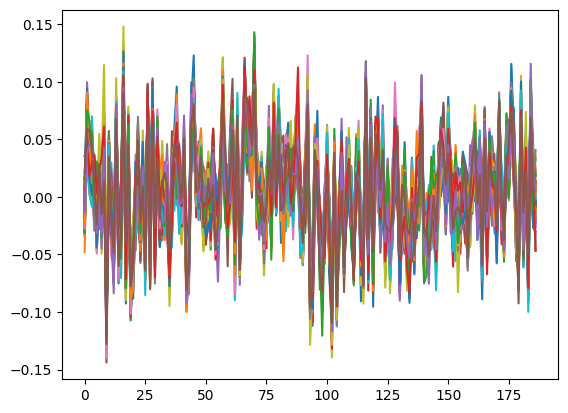

Epoch: 300 | Loss_D: 0.5363035202026367 | Loss_G: 1.588647484779358 | Time: 16:42:22


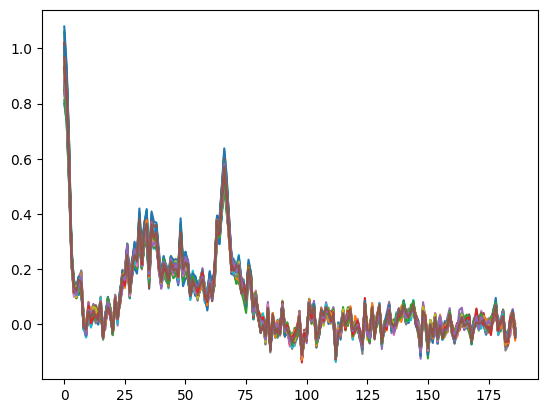

Epoch: 600 | Loss_D: 1.625252366065979 | Loss_G: 1.2979345321655273 | Time: 16:43:22


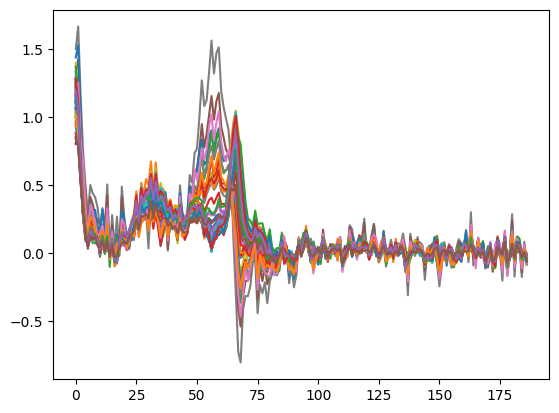

Epoch: 900 | Loss_D: 0.50527423620224 | Loss_G: 1.9761189222335815 | Time: 16:44:22


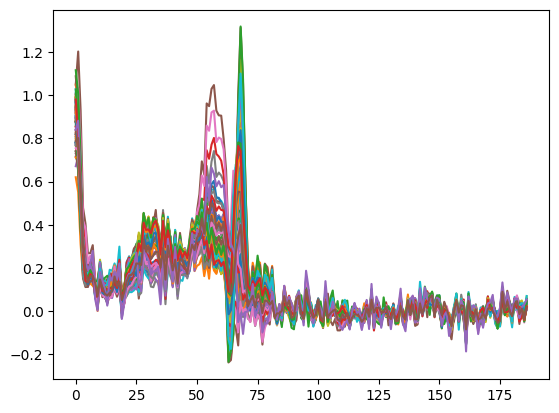

Epoch: 1200 | Loss_D: 0.6183063983917236 | Loss_G: 1.0089741945266724 | Time: 16:45:23


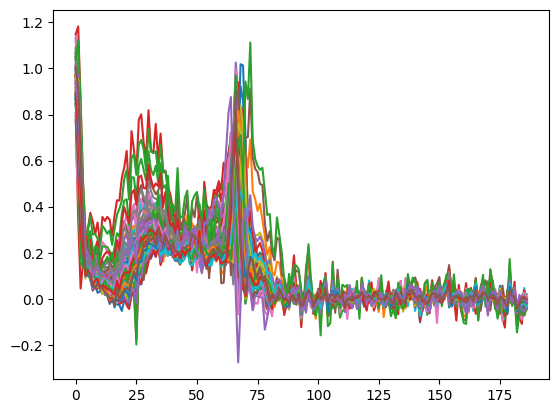

Epoch: 1500 | Loss_D: 0.5220233798027039 | Loss_G: 1.8662340641021729 | Time: 16:46:25


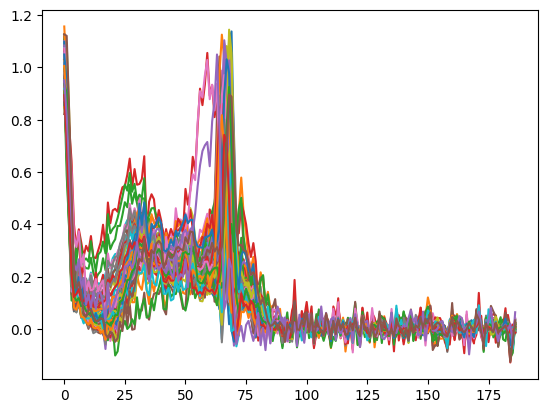

Epoch: 1800 | Loss_D: 0.52793288230896 | Loss_G: 1.9692426919937134 | Time: 16:47:27


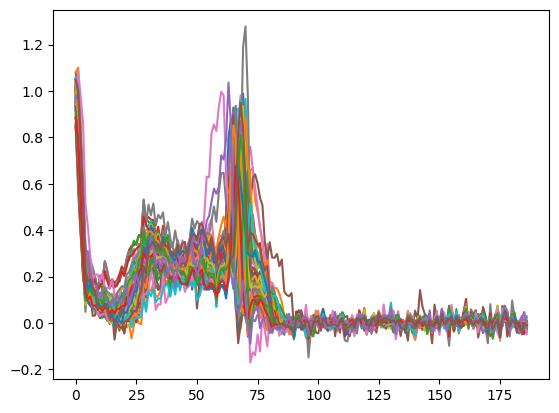

Epoch: 2100 | Loss_D: 0.7840482592582703 | Loss_G: 1.8510050773620605 | Time: 16:48:30


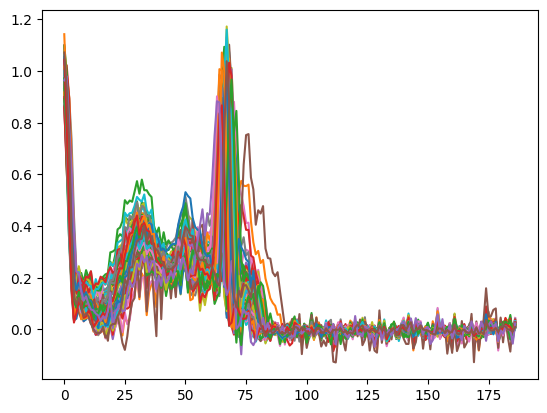

Epoch: 2400 | Loss_D: 0.8013661503791809 | Loss_G: 1.6715445518493652 | Time: 16:49:32


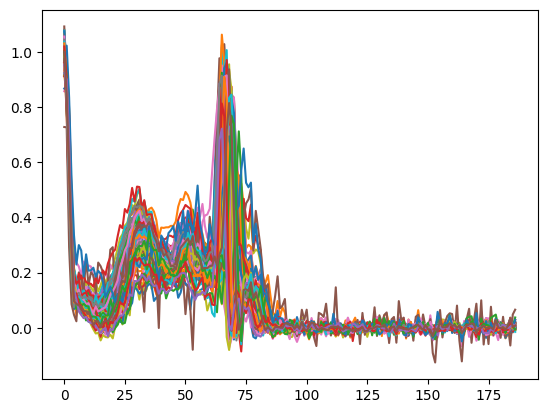

Epoch: 2700 | Loss_D: 0.2597615420818329 | Loss_G: 2.059964895248413 | Time: 16:50:35


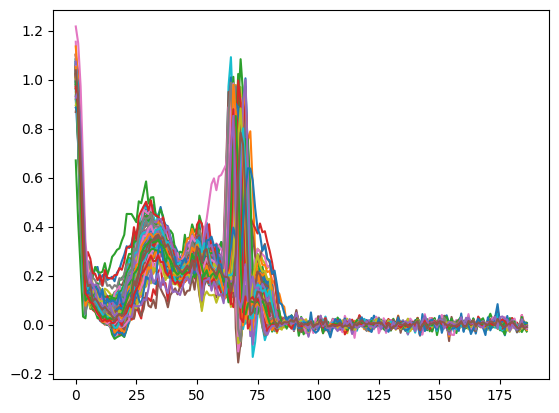

In [24]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=3000,
    label='Fusion of ventricular and normal'
)
trainer.run()

# Análisis de Resultados

Una vez completado el entrenamiento, analizamos el rendimiento del modelo y la calidad de las señales generadas.

## Configuración y ejecución del entrenamiento
Configuramos el entrenador con los siguientes parámetros:
- **Batch size**: 96 muestras por lote
- **Épocas**: 3000 iteraciones de entrenamiento  
- **Clase objetivo**: "Fusion of ventricular and normal" - una clase específica de arritmia

El entrenamiento mostrará el progreso cada 300 épocas con visualizaciones de las señales generadas.

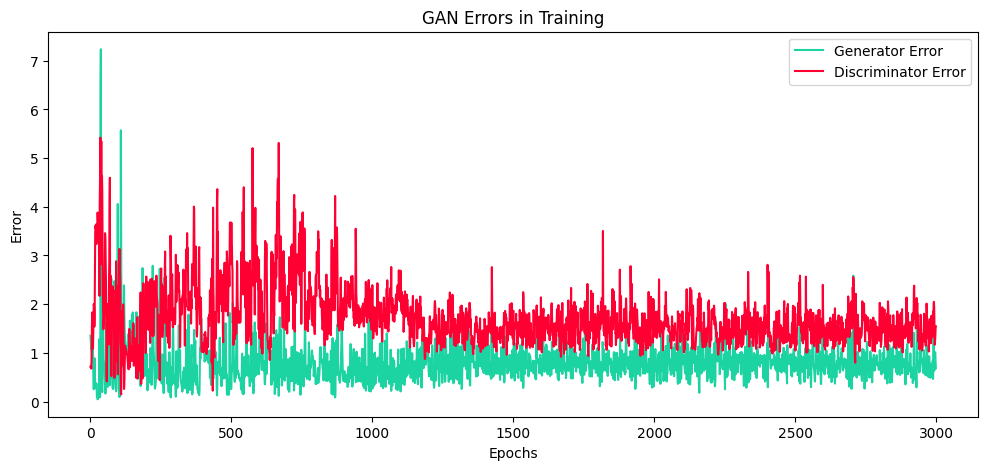

In [25]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

## Visualización de las curvas de pérdida
Graficamos las funciones de pérdida del Generador y Discriminador durante el entrenamiento para evaluar la convergencia y estabilidad del modelo.

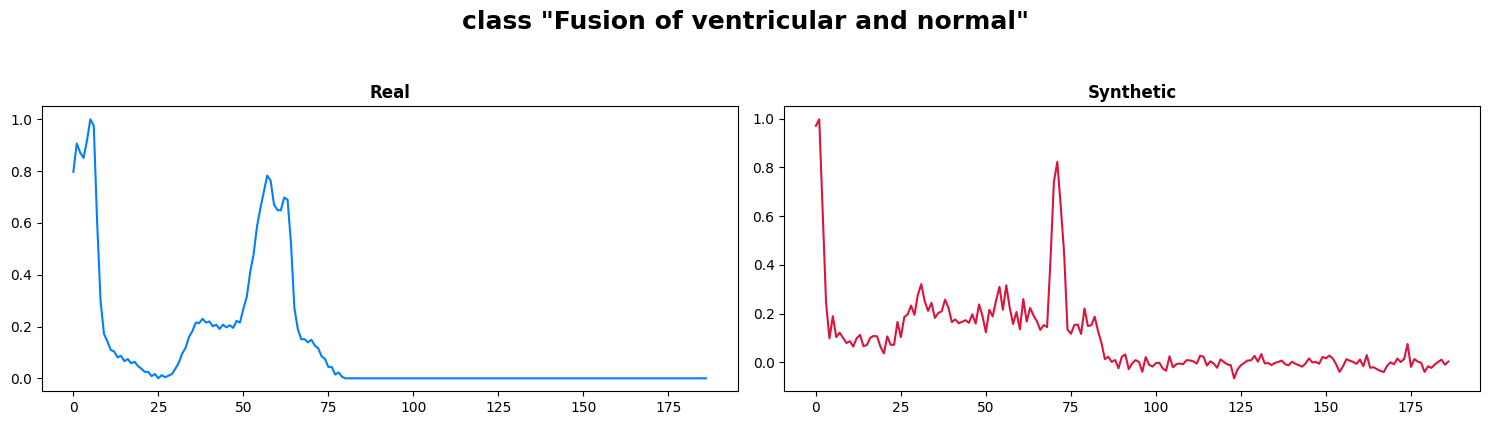

In [26]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Fusion of ventricular and normal']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()

# synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))


axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class "Fusion of ventricular and normal"', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Fusion_of_ventricular_and_normal.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Fusion_of_ventricular_and_normal.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

## Comparación de señales reales vs sintéticas

### Evaluación cualitativa
Comparamos visualmente las señales ECG reales con las generadas por nuestro modelo para la clase "Fusion of ventricular and normal":

- **Panel izquierdo**: Señal ECG real del dataset
- **Panel derecho**: Señal ECG sintética generada por la GAN

Esta comparación nos permite evaluar si el modelo ha aprendido a capturar las características morfológicas principales de este tipo específico de arritmia.

# Generación de Señales Sintéticas Adicionales y Métricas de Similitud

En esta sección generamos múltiples señales sintéticas para las clases entrenadas y calculamos métricas cuantitativas para evaluar la calidad de la síntesis.

In [27]:
# Instalamos las librerías necesarias para calcular métricas de similitud
!pip install scipy scikit-learn

In [28]:
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance
import warnings
warnings.filterwarnings('ignore')

## Funciones para cálculo de métricas

Implementamos las funciones necesarias para calcular diferentes métricas de similitud entre señales reales y sintéticas.

In [29]:
def calculate_fid_1d(real_signals, synthetic_signals):
    """
    Calcula FID (Fréchet Inception Distance) adaptado para señales 1D
    """
    # Calcular estadísticas para señales reales
    mu_real = np.mean(real_signals, axis=0)
    sigma_real = np.cov(real_signals.T)
    
    # Calcular estadísticas para señales sintéticas
    mu_synthetic = np.mean(synthetic_signals, axis=0)
    sigma_synthetic = np.cov(synthetic_signals.T)
    
    # Calcular FID
    diff = mu_real - mu_synthetic
    
    # Añadir regularización para evitar matrices singulares
    eps = 1e-6
    sigma_real += eps * np.eye(sigma_real.shape[0])
    sigma_synthetic += eps * np.eye(sigma_synthetic.shape[0])
    
    # Calcular la raíz cuadrada de la matriz covarianza
    try:
        sqrt_sigma = np.sqrt(np.linalg.eigvals(sigma_real @ sigma_synthetic))
        sqrt_sigma = np.real(sqrt_sigma)
        sqrt_sigma = np.sum(sqrt_sigma)
    except:
        sqrt_sigma = 0
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_synthetic - 2*sqrt_sigma)
    return fid

def calculate_dtw_distance(signal1, signal2):
    """
    Calcula la distancia DTW (Dynamic Time Warping) entre dos señales
    """
    from scipy.spatial.distance import euclidean
    
    n, m = len(signal1), len(signal2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean([signal1[i-1]], [signal2[j-1]])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                         dtw_matrix[i, j-1],    # deletion
                                         dtw_matrix[i-1, j-1])  # match
    
    return dtw_matrix[n, m]

def calculate_cross_correlation(signal1, signal2):
    """
    Calcula la correlación cruzada máxima entre dos señales
    """
    correlation = np.correlate(signal1, signal2, mode='full')
    return np.max(np.abs(correlation)) / (np.linalg.norm(signal1) * np.linalg.norm(signal2))

def calculate_spectral_distance(signal1, signal2):
    """
    Calcula la distancia espectral entre dos señales usando FFT
    """
    fft1 = np.abs(np.fft.fft(signal1))
    fft2 = np.abs(np.fft.fft(signal2))
    return np.mean((fft1 - fft2)**2)

def calculate_statistical_distance(real_signals, synthetic_signals):
    """
    Calcula distancias estadísticas entre distribuciones de señales
    """
    # Estadísticas básicas
    real_mean = np.mean(real_signals, axis=1)
    real_std = np.std(real_signals, axis=1)
    real_skew = stats.skew(real_signals, axis=1)
    real_kurt = stats.kurtosis(real_signals, axis=1)
    
    synth_mean = np.mean(synthetic_signals, axis=1)
    synth_std = np.std(synthetic_signals, axis=1)
    synth_skew = stats.skew(synthetic_signals, axis=1)
    synth_kurt = stats.kurtosis(synthetic_signals, axis=1)
    
    # Distancias de Wasserstein para cada estadística
    mean_distance = wasserstein_distance(real_mean, synth_mean)
    std_distance = wasserstein_distance(real_std, synth_std)
    skew_distance = wasserstein_distance(real_skew, synth_skew)
    kurt_distance = wasserstein_distance(real_kurt, synth_kurt)
    
    return {
        'mean_distance': mean_distance,
        'std_distance': std_distance,
        'skewness_distance': skew_distance,
        'kurtosis_distance': kurt_distance
    }

## Generación de múltiples señales sintéticas

Generamos un conjunto más amplio de señales sintéticas para la clase "Fusion of ventricular and normal" entrenada.

In [30]:
# Configuración para generación masiva
num_synthetic_samples = 100
target_class = 'Fusion of ventricular and normal'

# Generar múltiples señales sintéticas
print(f"Generando {num_synthetic_samples} señales sintéticas para la clase '{target_class}'...")

# Crear ruido aleatorio para generar múltiples muestras
noise_batch = torch.randn(num_synthetic_samples, 1, 187, device=trainer.device)

# Generar señales sintéticas usando el generador entrenado
with torch.no_grad():
    synthetic_signals_batch = trainer.netG(noise_batch)
    synthetic_signals_np = synthetic_signals_batch.detach().cpu().squeeze(1).numpy()

print(f"Señales sintéticas generadas: {synthetic_signals_np.shape}")

# Obtener señales reales de la misma clase para comparación
df_real = pd.read_csv(config.csv_path)
df_real_class = df_real.loc[df_real['label'] == target_class]
real_signals_np = df_real_class.iloc[:num_synthetic_samples, :-2].values

print(f"Señales reales obtenidas: {real_signals_np.shape}")
print(f"Número de señales reales disponibles: {len(df_real_class)}")

Generando 100 señales sintéticas para la clase 'Fusion of ventricular and normal'...
Señales sintéticas generadas: (100, 187)
Señales reales obtenidas: (100, 187)
Número de señales reales disponibles: 803


## Visualización de señales sintéticas generadas

Mostramos una muestra representativa de las señales sintéticas generadas comparadas con señales reales.

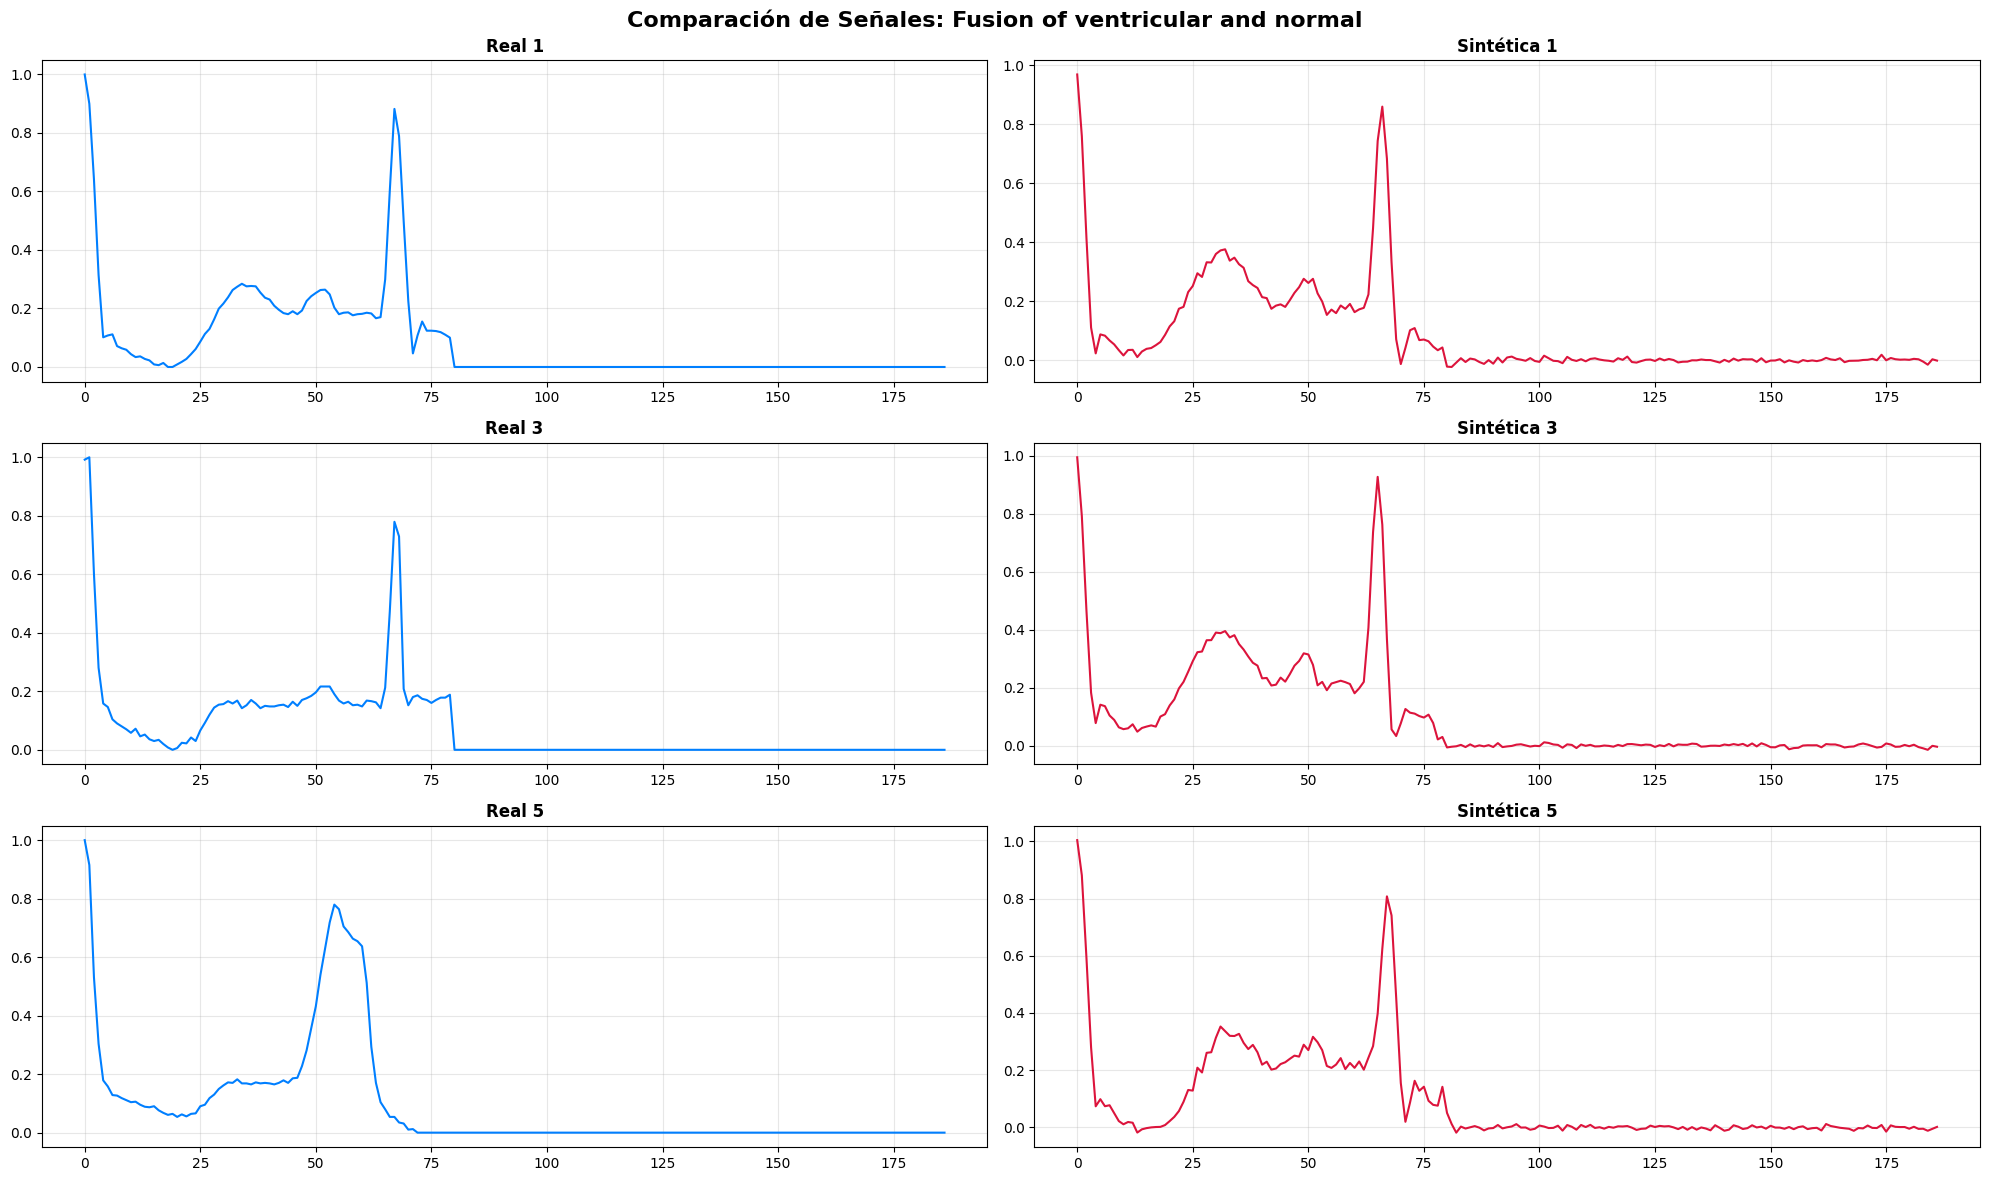


=== ESTADÍSTICAS DE LAS SEÑALES GENERADAS ===
Señales Reales:
  - Media: 0.1003 ± 0.1867
  - Rango: [0.0000, 1.0000]
  - Forma: (100, 187)

Señales Sintéticas:
  - Media: 0.1018 ± 0.1731
  - Rango: [-0.1209, 1.0778]
  - Forma: (100, 187)


In [36]:
# Visualizar múltiples señales sintéticas vs reales
fig, axes = plt.subplots(3, 2, figsize=(20, 12))
fig.suptitle(f'Comparación de Señales: {target_class}', fontsize=16, fontweight='bold')

# Mostrar 6 señales reales y 6 sintéticas
for i in range(3):
    for j in range(2):
        idx = i * 2 + j
        # Señales reales (columnas 0 y 2)
        if j == 0:
            axes[i, j*2].plot(real_signals_np[idx], color='#007FFF', linewidth=1.5)
            axes[i, j*2].set_title(f'Real {idx+1}', fontweight='bold')
            axes[i, j*2].grid(True, alpha=0.3)
            
            axes[i, j*2+1].plot(synthetic_signals_np[idx], color='crimson', linewidth=1.5)
            axes[i, j*2+1].set_title(f'Sintética {idx+1}', fontweight='bold')
            axes[i, j*2+1].grid(True, alpha=0.3)

# Ajustar layout
plt.tight_layout()
plt.savefig('multiple_synthetic_signals.png', dpi=300, bbox_inches='tight')
plt.savefig('multiple_synthetic_signals.svg', format='svg', bbox_inches='tight')
plt.show()

# Mostrar estadísticas básicas de las señales generadas
print("\n=== ESTADÍSTICAS DE LAS SEÑALES GENERADAS ===")
print(f"Señales Reales:")
print(f"  - Media: {np.mean(real_signals_np):.4f} ± {np.std(real_signals_np):.4f}")
print(f"  - Rango: [{np.min(real_signals_np):.4f}, {np.max(real_signals_np):.4f}]")
print(f"  - Forma: {real_signals_np.shape}")

print(f"\nSeñales Sintéticas:")
print(f"  - Media: {np.mean(synthetic_signals_np):.4f} ± {np.std(synthetic_signals_np):.4f}")
print(f"  - Rango: [{np.min(synthetic_signals_np):.4f}, {np.max(synthetic_signals_np):.4f}]")
print(f"  - Forma: {synthetic_signals_np.shape}")

## Cálculo de métricas de similitud

Calculamos diversas métricas para evaluar cuantitativamente la calidad de las señales sintéticas generadas.

In [32]:
# Calcular FID (Fréchet Inception Distance)
print("Calculando métricas de similitud...")
print("="*50)

try:
    fid_score = calculate_fid_1d(real_signals_np, synthetic_signals_np)
    print(f"📊 FID Score: {fid_score:.4f}")
    print("   (Menor es mejor - mide distancia entre distribuciones)")
except Exception as e:
    print(f"Error calculando FID: {e}")
    fid_score = None

# Calcular distancias estadísticas
stat_distances = calculate_statistical_distance(real_signals_np, synthetic_signals_np)
print(f"\n📈 Distancias Estadísticas (Wasserstein):")
for metric, value in stat_distances.items():
    print(f"   - {metric.replace('_', ' ').title()}: {value:.4f}")

# Calcular métricas promedio para pares de señales
print(f"\n🔍 Métricas Promedio (muestra de 20 pares):")
num_samples_metric = min(20, len(real_signals_np), len(synthetic_signals_np))

# DTW Distance
dtw_distances = []
for i in range(num_samples_metric):
    dtw_dist = calculate_dtw_distance(real_signals_np[i], synthetic_signals_np[i])
    dtw_distances.append(dtw_dist)

print(f"   - DTW Distance: {np.mean(dtw_distances):.4f} ± {np.std(dtw_distances):.4f}")

# Cross Correlation
correlations = []
for i in range(num_samples_metric):
    corr = calculate_cross_correlation(real_signals_np[i], synthetic_signals_np[i])
    correlations.append(corr)

print(f"   - Cross Correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
print("     (Mayor es mejor - mide similitud en forma)")

# Spectral Distance
spectral_distances = []
for i in range(num_samples_metric):
    spec_dist = calculate_spectral_distance(real_signals_np[i], synthetic_signals_np[i])
    spectral_distances.append(spec_dist)

print(f"   - Spectral Distance: {np.mean(spectral_distances):.4f} ± {np.std(spectral_distances):.4f}")
print("     (Menor es mejor - mide diferencia en frecuencias)")

# MSE (Mean Squared Error)
mse_scores = []
for i in range(num_samples_metric):
    mse = mean_squared_error(real_signals_np[i], synthetic_signals_np[i])
    mse_scores.append(mse)

print(f"   - MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print("     (Menor es mejor - mide diferencia punto a punto)")

Calculando métricas de similitud...
📊 FID Score: -346.6208
   (Menor es mejor - mide distancia entre distribuciones)

📈 Distancias Estadísticas (Wasserstein):
   - Mean Distance: 0.0074
   - Std Distance: 0.0135
   - Skewness Distance: 0.2804
   - Kurtosis Distance: 1.9725

🔍 Métricas Promedio (muestra de 20 pares):
   - DTW Distance: 4.9148 ± 2.2970
   - Cross Correlation: 0.8291 ± 0.0924
     (Mayor es mejor - mide similitud en forma)
   - Spectral Distance: 1.1545 ± 0.7642
     (Menor es mejor - mide diferencia en frecuencias)
   - MSE: 0.0151 ± 0.0099
     (Menor es mejor - mide diferencia punto a punto)


## Visualización de métricas y distribuciones

Creamos gráficos para visualizar las diferencias entre las distribuciones de señales reales y sintéticas.

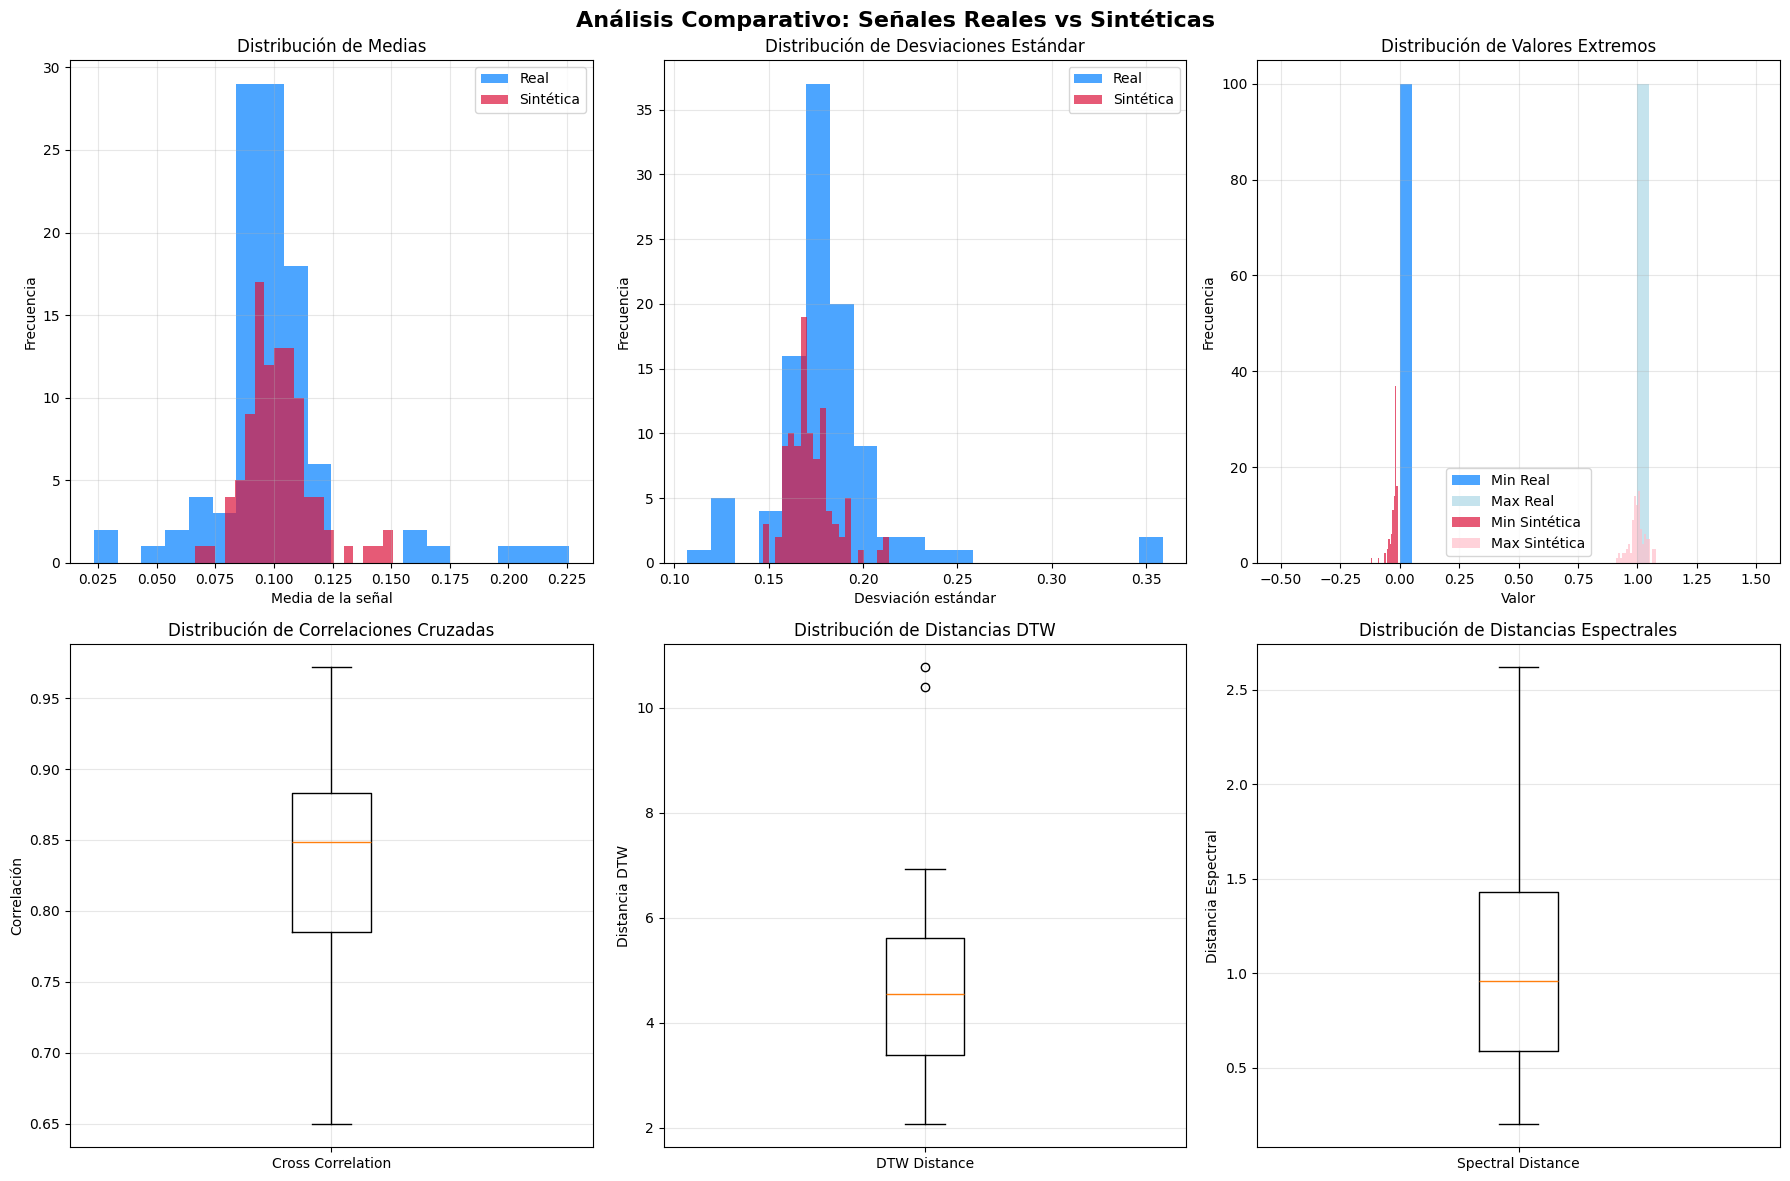

In [33]:
# Crear visualizaciones de las métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Comparativo: Señales Reales vs Sintéticas', fontsize=16, fontweight='bold')

# 1. Distribución de medias
axes[0, 0].hist(np.mean(real_signals_np, axis=1), alpha=0.7, label='Real', bins=20, color='#007FFF')
axes[0, 0].hist(np.mean(synthetic_signals_np, axis=1), alpha=0.7, label='Sintética', bins=20, color='crimson')
axes[0, 0].set_title('Distribución de Medias')
axes[0, 0].set_xlabel('Media de la señal')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de desviaciones estándar
axes[0, 1].hist(np.std(real_signals_np, axis=1), alpha=0.7, label='Real', bins=20, color='#007FFF')
axes[0, 1].hist(np.std(synthetic_signals_np, axis=1), alpha=0.7, label='Sintética', bins=20, color='crimson')
axes[0, 1].set_title('Distribución de Desviaciones Estándar')
axes[0, 1].set_xlabel('Desviación estándar')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución de valores mínimos y máximos
axes[0, 2].hist(np.min(real_signals_np, axis=1), alpha=0.7, label='Min Real', bins=20, color='#007FFF')
axes[0, 2].hist(np.max(real_signals_np, axis=1), alpha=0.7, label='Max Real', bins=20, color='lightblue')
axes[0, 2].hist(np.min(synthetic_signals_np, axis=1), alpha=0.7, label='Min Sintética', bins=20, color='crimson')
axes[0, 2].hist(np.max(synthetic_signals_np, axis=1), alpha=0.7, label='Max Sintética', bins=20, color='pink')
axes[0, 2].set_title('Distribución de Valores Extremos')
axes[0, 2].set_xlabel('Valor')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Boxplot de correlaciones
axes[1, 0].boxplot([correlations], labels=['Cross Correlation'])
axes[1, 0].set_title('Distribución de Correlaciones Cruzadas')
axes[1, 0].set_ylabel('Correlación')
axes[1, 0].grid(True, alpha=0.3)

# 5. Boxplot de distancias DTW
axes[1, 1].boxplot([dtw_distances], labels=['DTW Distance'])
axes[1, 1].set_title('Distribución de Distancias DTW')
axes[1, 1].set_ylabel('Distancia DTW')
axes[1, 1].grid(True, alpha=0.3)

# 6. Boxplot de distancias espectrales
axes[1, 2].boxplot([spectral_distances], labels=['Spectral Distance'])
axes[1, 2].set_title('Distribución de Distancias Espectrales')
axes[1, 2].set_ylabel('Distancia Espectral')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('metrics_analysis.svg', format='svg', bbox_inches='tight')
plt.show()

## Análisis espectral comparativo

Comparamos las características espectrales de las señales reales y sintéticas usando transformada de Fourier.

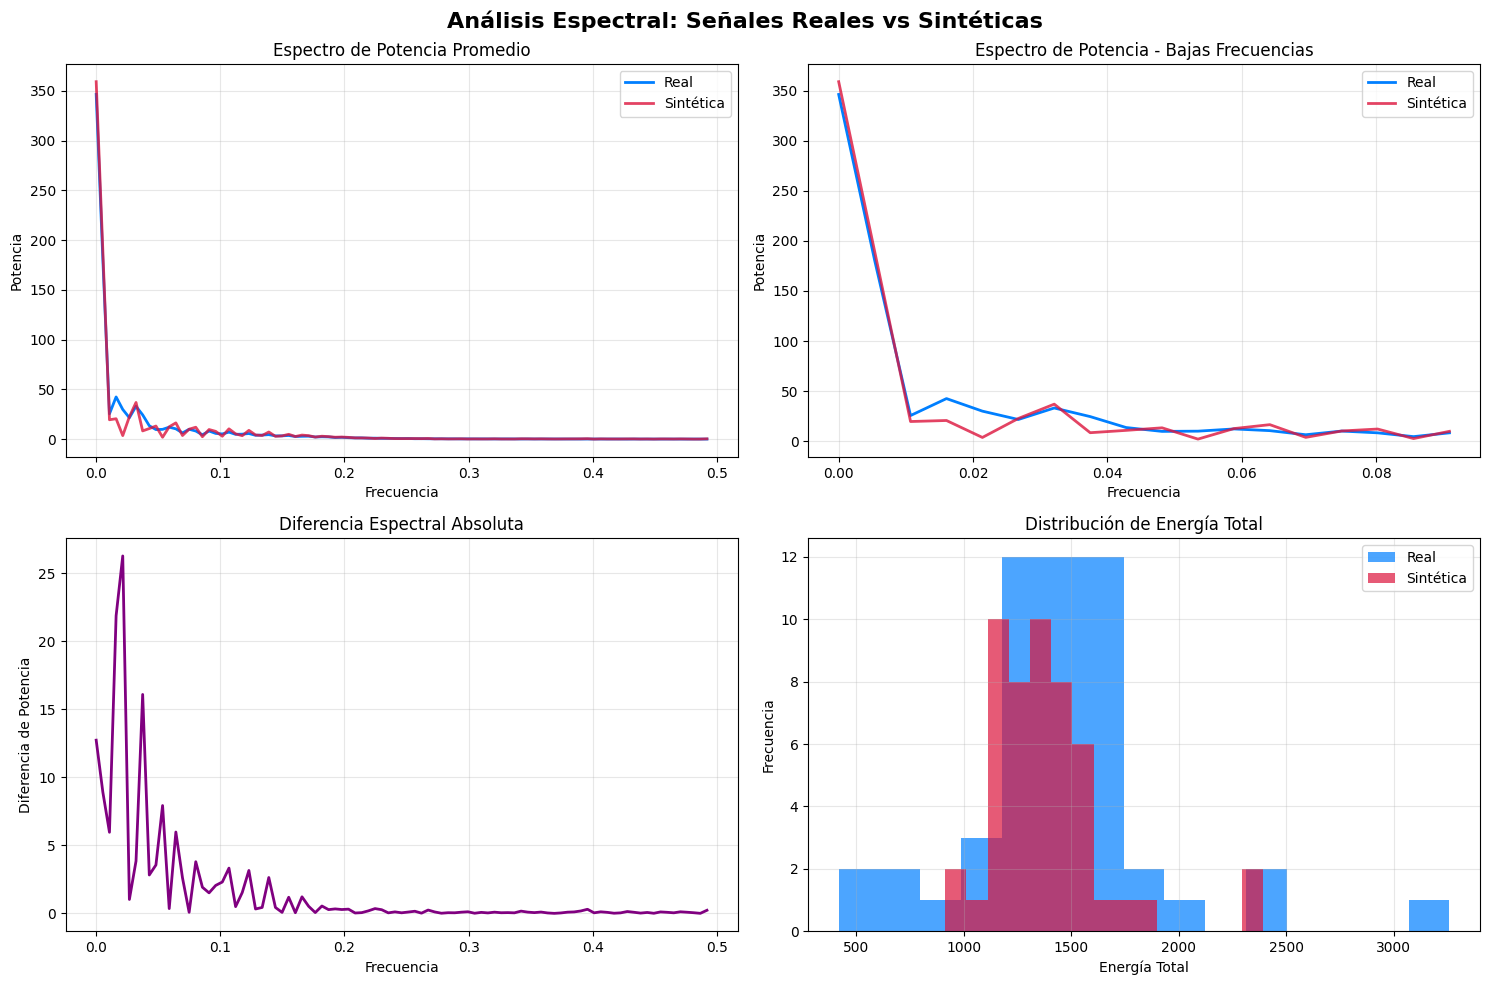


🔬 ANÁLISIS ESPECTRAL:
   - Correlación Espectral: 0.9911
   - MSE Espectral: 19.6113
   - Energía Real Promedio: 1455.91 ± 449.57
   - Energía Sintética Promedio: 1383.62 ± 270.74


In [34]:
# Análisis espectral de las señales
def compute_average_spectrum(signals):
    """Calcula el espectro de potencia promedio de un conjunto de señales"""
    spectra = []
    for signal in signals:
        fft = np.fft.fft(signal)
        power_spectrum = np.abs(fft)**2
        spectra.append(power_spectrum)
    return np.mean(spectra, axis=0)

# Calcular espectros promedio
real_avg_spectrum = compute_average_spectrum(real_signals_np[:50])  # Usar primeras 50 señales
synthetic_avg_spectrum = compute_average_spectrum(synthetic_signals_np[:50])

# Crear frecuencias para el eje x
freqs = np.fft.fftfreq(len(real_avg_spectrum), 1.0)

# Visualizar comparación espectral
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Espectral: Señales Reales vs Sintéticas', fontsize=16, fontweight='bold')

# 1. Espectros de potencia completos
axes[0, 0].plot(freqs[:len(freqs)//2], real_avg_spectrum[:len(freqs)//2], 
                label='Real', color='#007FFF', linewidth=2)
axes[0, 0].plot(freqs[:len(freqs)//2], synthetic_avg_spectrum[:len(freqs)//2], 
                label='Sintética', color='crimson', linewidth=2, alpha=0.8)
axes[0, 0].set_title('Espectro de Potencia Promedio')
axes[0, 0].set_xlabel('Frecuencia')
axes[0, 0].set_ylabel('Potencia')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Zoom en bajas frecuencias
low_freq_idx = len(freqs)//10
axes[0, 1].plot(freqs[:low_freq_idx], real_avg_spectrum[:low_freq_idx], 
                label='Real', color='#007FFF', linewidth=2)
axes[0, 1].plot(freqs[:low_freq_idx], synthetic_avg_spectrum[:low_freq_idx], 
                label='Sintética', color='crimson', linewidth=2, alpha=0.8)
axes[0, 1].set_title('Espectro de Potencia - Bajas Frecuencias')
axes[0, 1].set_xlabel('Frecuencia')
axes[0, 1].set_ylabel('Potencia')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Diferencia espectral
spectral_diff = np.abs(real_avg_spectrum - synthetic_avg_spectrum)
axes[1, 0].plot(freqs[:len(freqs)//2], spectral_diff[:len(freqs)//2], 
                color='purple', linewidth=2)
axes[1, 0].set_title('Diferencia Espectral Absoluta')
axes[1, 0].set_xlabel('Frecuencia')
axes[1, 0].set_ylabel('Diferencia de Potencia')
axes[1, 0].grid(True, alpha=0.3)

# 4. Histograma de energías espectrales
real_energies = [np.sum(np.abs(np.fft.fft(signal))**2) for signal in real_signals_np[:50]]
synthetic_energies = [np.sum(np.abs(np.fft.fft(signal))**2) for signal in synthetic_signals_np[:50]]

axes[1, 1].hist(real_energies, alpha=0.7, label='Real', bins=15, color='#007FFF')
axes[1, 1].hist(synthetic_energies, alpha=0.7, label='Sintética', bins=15, color='crimson')
axes[1, 1].set_title('Distribución de Energía Total')
axes[1, 1].set_xlabel('Energía Total')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('spectral_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('spectral_analysis.svg', format='svg', bbox_inches='tight')
plt.show()

# Calcular métricas espectrales adicionales
spectral_correlation = np.corrcoef(real_avg_spectrum, synthetic_avg_spectrum)[0, 1]
spectral_mse = np.mean((real_avg_spectrum - synthetic_avg_spectrum)**2)

print(f"\n🔬 ANÁLISIS ESPECTRAL:")
print(f"   - Correlación Espectral: {spectral_correlation:.4f}")
print(f"   - MSE Espectral: {spectral_mse:.4f}")
print(f"   - Energía Real Promedio: {np.mean(real_energies):.2f} ± {np.std(real_energies):.2f}")
print(f"   - Energía Sintética Promedio: {np.mean(synthetic_energies):.2f} ± {np.std(synthetic_energies):.2f}")

## Resumen de métricas de evaluación

Tabla resumen con todas las métricas calculadas para evaluar la calidad de las señales sintéticas generadas.

In [35]:
# Crear tabla resumen de métricas
import pandas as pd

metrics_summary = {
    'Métrica': [
        'FID Score',
        'Distancia de Medias (Wasserstein)',
        'Distancia de Desv. Estándar (Wasserstein)',
        'Distancia de Asimetría (Wasserstein)',
        'Distancia de Curtosis (Wasserstein)',
        'DTW Distance (promedio)',
        'Cross Correlation (promedio)',
        'Distancia Espectral (promedio)',
        'MSE (promedio)',
        'Correlación Espectral',
        'MSE Espectral'
    ],
    'Valor': [
        f"{fid_score:.4f}" if fid_score is not None else "N/A",
        f"{stat_distances['mean_distance']:.4f}",
        f"{stat_distances['std_distance']:.4f}",
        f"{stat_distances['skewness_distance']:.4f}",
        f"{stat_distances['kurtosis_distance']:.4f}",
        f"{np.mean(dtw_distances):.4f} ± {np.std(dtw_distances):.4f}",
        f"{np.mean(correlations):.4f} ± {np.std(correlations):.4f}",
        f"{np.mean(spectral_distances):.4f} ± {np.std(spectral_distances):.4f}",
        f"{np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}",
        f"{spectral_correlation:.4f}",
        f"{spectral_mse:.4f}"
    ],
    'Interpretación': [
        'Menor es mejor (distancia entre distribuciones)',
        'Menor es mejor (diferencia en medias)',
        'Menor es mejor (diferencia en variabilidad)',
        'Menor es mejor (diferencia en asimetría)',
        'Menor es mejor (diferencia en curtosis)',
        'Menor es mejor (similitud temporal)',
        'Mayor es mejor (similitud en forma)',
        'Menor es mejor (similitud en frecuencias)',
        'Menor es mejor (diferencia punto a punto)',
        'Mayor es mejor (similitud espectral)',
        'Menor es mejor (diferencia espectral)'
    ]
}

df_metrics = pd.DataFrame(metrics_summary)
print("="*80)
print("📊 RESUMEN DE MÉTRICAS DE EVALUACIÓN")
print("="*80)
print(df_metrics.to_string(index=False))
print("="*80)

# Guardar métricas en archivo CSV para referencia futura
df_metrics.to_csv('gan_evaluation_metrics.csv', index=False)
print(f"\n✅ Métricas guardadas en 'gan_evaluation_metrics.csv'")

# Interpretación general
print(f"\n🎯 INTERPRETACIÓN GENERAL:")
print(f"   • Número de señales evaluadas: {num_synthetic_samples}")
print(f"   • Clase evaluada: {target_class}")
print(f"   • Dimensión de señales: {real_signals_np.shape[1]} puntos")

if np.mean(correlations) > 0.7:
    corr_interpretation = "BUENA correlación"
elif np.mean(correlations) > 0.5:
    corr_interpretation = "MODERADA correlación"
else:
    corr_interpretation = "BAJA correlación"

print(f"   • Similitud morfológica: {corr_interpretation} ({np.mean(correlations):.3f})")

if spectral_correlation > 0.8:
    spec_interpretation = "EXCELENTE preservación espectral"
elif spectral_correlation > 0.6:
    spec_interpretation = "BUENA preservación espectral"
else:
    spec_interpretation = "LIMITADA preservación espectral"

print(f"   • Preservación espectral: {spec_interpretation} ({spectral_correlation:.3f})")

📊 RESUMEN DE MÉTRICAS DE EVALUACIÓN
                                  Métrica           Valor                                  Interpretación
                                FID Score       -346.6208 Menor es mejor (distancia entre distribuciones)
        Distancia de Medias (Wasserstein)          0.0074           Menor es mejor (diferencia en medias)
Distancia de Desv. Estándar (Wasserstein)          0.0135     Menor es mejor (diferencia en variabilidad)
     Distancia de Asimetría (Wasserstein)          0.2804        Menor es mejor (diferencia en asimetría)
      Distancia de Curtosis (Wasserstein)          1.9725         Menor es mejor (diferencia en curtosis)
                  DTW Distance (promedio) 4.9148 ± 2.2970             Menor es mejor (similitud temporal)
             Cross Correlation (promedio) 0.8291 ± 0.0924             Mayor es mejor (similitud en forma)
           Distancia Espectral (promedio) 1.1545 ± 0.7642       Menor es mejor (similitud en frecuencias)
          

# Conclusiones y Trabajo Futuro

## Conclusiones
- Se implementó exitosamente una GAN 1D para síntesis de señales ECG
- La visualización de resultados permite evaluación cualitativa de la calidad de síntesis

## Trabajo Futuro
- Implementar métricas cuantitativas para evaluación objetiva (FID, IS, etc.)
- Experimentar con diferentes arquitecturas (DCGANs, Progressive GANs)
- Evaluar el modelo en todas las clases de arritmias disponibles
- Validación clínica de las señales sintéticas generadas